In [152]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import datetime as dt

import xgboost as xgb

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

from google.colab import drive
drive.mount('/content/drive')
drive_dir = '/content/drive/My Drive/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [153]:
df = pd.read_csv(drive_dir + 'model_df.csv')
#df = df.fillna(0)

In [154]:
df.head()

,date,Y,M,D,home_team,away_team,home_win,home_pitcher,away_pitcher,home_elo,away_elo,home_avg,away_avg,home_obp,away_obp,home_slg,away_slg,home_iso,away_iso,elo_diff,elo_pct_diff,avg_diff,obp_diff,slg_diff,avg_pct_diff,obp_pct_diff,slg_pct_diff,home_rest,away_rest,away_team_season_game_num,home_team_season_game_num,home_Avg_Attendance_offset1year,home_W-L-pct_offset1year,away_Avg_Attendance_offset1year,away_W-L-pct_offset1year,team_home_WHIP_offset1year,team_home_ERA_offset1year,team_away_WHIP_offset1year,team_away_ERA_offset1year,pitcher_home_WHIP_offset1game,pitcher_home_ERA_offset1game,pitcher_home_IP_offset1game,pitcher_away_WHIP_offset1game,pitcher_away_ERA_offset1game,pitcher_away_IP_offset1game,home_ops,away_ops,pitcher_WHIP_diff,pitcher_ERA_diff,pitcher_IP_diff,team_WHIP_diff,W-L_diff,team_ERA_diff,ops_diff,pitcher_WHIP_pct_diff,pitcher_ERA_pct_diff,pitcher_IP_pct_diff,team_ERA_pct_diff,ops_pct_diff
0,2001-04-01,2001,4.0,1.0,TOR,TEX,1.0,loaizes01,helliri01,1499.563,1479.163,0.273459,0.281519,0.339283,0.349386,0.466387,0.443116,0.192927,0.161597,20.400,1.360396,-0.008060,-0.010103,0.023271,-2.947374,-2.977845,4.989568,5.0,5.0,0,0,24861.419753,0.512346,32341.993789,0.438272,1.513465,5.17,1.640308,5.52,NaN,NaN,NaN,NaN,NaN,NaN,0.805669,0.792502,NaN,NaN,NaN,-8.380988,0.074074,-0.35,0.013167,NaN,NaN,NaN,-6.769826,1.634335
1,2001-04-02,2001,4.0,2.0,LAN,MIL,1.0,parkch01,wrighja01,1515.925,1490.396,0.254198,0.243537,0.336984,0.322708,0.426431,0.400071,0.172233,0.156534,25.529,1.684054,0.010660,0.014276,0.026359,4.193722,4.236467,6.181414,5.0,5.0,0,0,35699.943750,0.530864,23547.447205,0.450617,1.369550,4.10,1.520360,4.63,NaN,NaN,NaN,NaN,NaN,NaN,0.763415,0.722779,NaN,NaN,NaN,-11.011642,0.080247,-0.53,0.040636,NaN,NaN,NaN,-12.926829,5.322882
2,2001-04-02,2001,4.0,2.0,MIA,PHI,0.0,dempsry01,daalom01,1485.779,1469.581,0.258568,0.249414,0.327653,0.326710,0.404271,0.395387,0.145703,0.145972,16.198,1.090203,0.009154,0.000942,0.008884,3.540184,0.287582,2.197547,5.0,5.0,0,0,22040.418750,0.490683,25348.602484,0.401235,1.488245,4.59,1.458768,4.79,NaN,NaN,NaN,NaN,NaN,NaN,0.731923,0.722097,NaN,NaN,NaN,1.980673,0.089449,-0.20,0.009826,NaN,NaN,NaN,-4.357298,1.342533
3,2001-04-02,2001,4.0,2.0,SEA,OAK,1.0,garcifr03,hudsoti01,1519.464,1534.696,0.267280,0.268144,0.358599,0.357409,0.438008,0.454237,0.170727,0.186092,-15.232,-1.002459,-0.000864,0.001190,-0.016229,-0.323318,0.331871,-3.705210,5.0,5.0,0,0,33215.672840,0.561728,26058.875776,0.565217,1.440466,4.53,1.498153,4.58,NaN,NaN,NaN,NaN,NaN,NaN,0.796607,0.811646,NaN,NaN,NaN,-4.004756,-0.003489,-0.05,-0.015039,NaN,NaN,NaN,-1.103753,-1.887882
4,2001-04-02,2001,4.0,2.0,SFN,SDN,1.0,hernali01,williwo02,1540.841,1492.800,0.276079,0.251828,0.359380,0.327088,0.468525,0.398252,0.192446,0.146424,48.041,3.117843,0.024251,0.032292,0.070273,8.784099,8.985458,14.998766,5.0,5.0,0,0,36484.765432,0.598765,29863.506173,0.469136,1.436881,4.21,1.433761,4.52,NaN,NaN,NaN,NaN,NaN,NaN,0.827905,0.725340,NaN,NaN,NaN,0.217176,0.129630,-0.31,0.102565,NaN,NaN,NaN,-7.363420,12.388486


In [155]:
df['pitcher_WHIP_pct_diff'].isnull().sum() / df['pitcher_WHIP_pct_diff'].shape[0]

0.06836429603251923

In [156]:
df[df['pitcher_WHIP_pct_diff'].isin([np.inf, -np.inf])].shape

(41, 59)

In [157]:
c = 0
for col in df.columns:
  print(df[df[col].isin([np.inf, -np.inf])].shape[0])

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
41
36
26
0
0


In [158]:
df.columns

Index(['date', 'Y', 'M', 'D', 'home_team', 'away_team', 'home_win',
       'home_pitcher', 'away_pitcher', 'home_elo', 'away_elo', 'home_avg',
       'away_avg', 'home_obp', 'away_obp', 'home_slg', 'away_slg', 'home_iso',
       'away_iso', 'elo_diff', 'elo_pct_diff', 'avg_diff', 'obp_diff',
       'slg_diff', 'avg_pct_diff', 'obp_pct_diff', 'slg_pct_diff', 'home_rest',
       'away_rest', 'away_team_season_game_num', 'home_team_season_game_num',
       'home_Avg_Attendance_offset1year', 'home_W-L-pct_offset1year',
       'away_Avg_Attendance_offset1year', 'away_W-L-pct_offset1year',
       'team_home_WHIP_offset1year', 'team_home_ERA_offset1year',
       'team_away_WHIP_offset1year', 'team_away_ERA_offset1year',
       'pitcher_home_WHIP_offset1game', 'pitcher_home_ERA_offset1game',
       'pitcher_home_IP_offset1game', 'pitcher_away_WHIP_offset1game',
       'pitcher_away_ERA_offset1game', 'pitcher_away_IP_offset1game',
       'home_ops', 'away_ops', 'pitcher_WHIP_diff', 'pitcher_ERA

In [159]:
df['home_win'] = df['home_win'].astype(int)

In [160]:
df = df.drop(['date','home_team', 'away_team', 'home_pitcher', 'away_pitcher'], axis=1)

In [161]:
train = df[df['Y'] <= 2015]
test = df[df['Y'] > 2015]

In [162]:
train = train.drop('Y', axis=1)
test= test.drop('Y', axis=1)

In [163]:
X_train = train.drop('home_win', axis=1)
y_train = train.home_win
X_test = test.drop('home_win', axis=1)
y_test = test.home_win

In [164]:
model = xgb.XGBClassifier()
xgb_model = model.fit(X_train, y_train)

In [165]:
preds = xgb_model.predict(X_test)

In [166]:
accuracy_score(y_test, preds)

0.7337429595494112

In [167]:
model = xgb.XGBClassifier(max_depth=3, learning_rate=0.05, n_estimators=300,)# importance_type='total_gain')
xgb_m = model.fit(X_train, y_train)

In [172]:
import joblib

joblib.dump(xgb_m, drive_dir + 'xgb_baseball_model.joblib') 

['/content/drive/My Drive/xgb_baseball_model.joblib']

In [168]:
preds = xgb_m.predict(X_test)

In [169]:
accuracy_score(y_test, preds)

0.7357910906298003

In [70]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.73      0.68      0.71      2751
           1       0.73      0.78      0.76      3108

    accuracy                           0.73      5859
   macro avg       0.73      0.73      0.73      5859
weighted avg       0.73      0.73      0.73      5859



In [71]:
featuredf = pd.DataFrame(xgb_m.feature_importances_, X_train.columns)   #This makes it in order
featuredf = featuredf.sort_values(by=0, ascending=False)

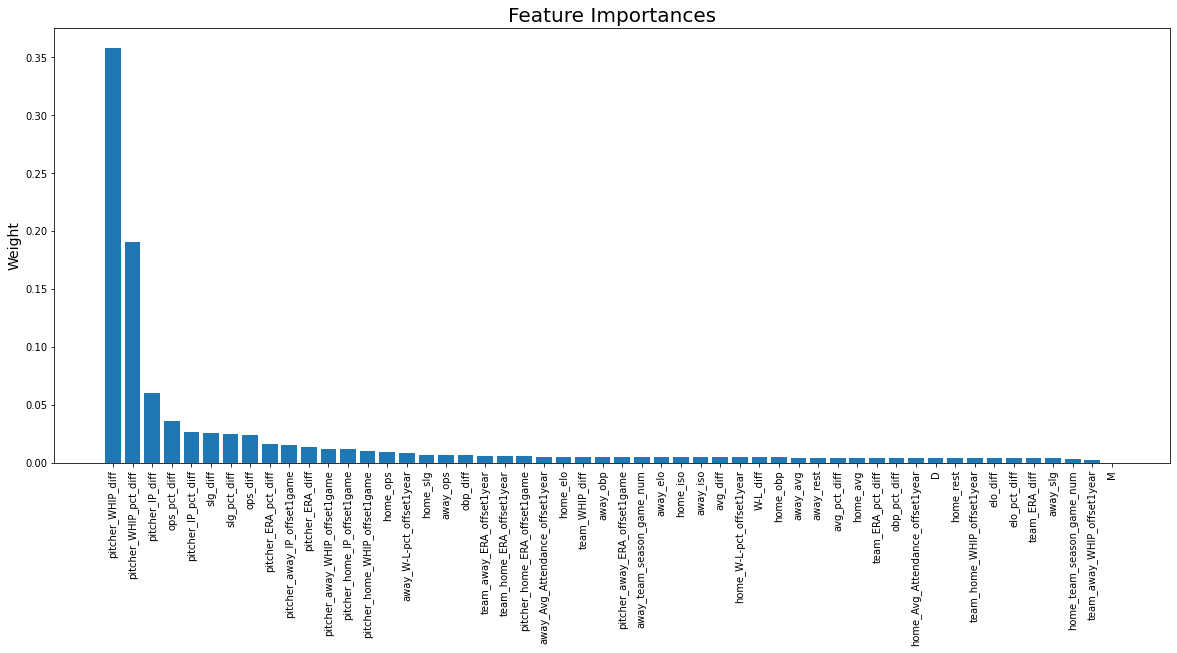

In [72]:
plt.figure(figsize=(20, 8))

x = featuredf.index
y = featuredf[0]

plt.bar(x, y)
#plt.xticks([0,1,2,3,4,5,6,7,8], ['OBP', 'ISO', 'WHIP', 'K/BB', 'FIP', 'K/9', 'ELO', 'HR/9', 'Rest Days'])
plt.xticks(rotation=90)
plt.title('Feature Importances', fontsize=20)
plt.ylabel('Weight', fontsize=14)
plt.savefig(drive_dir + 'feature_importance.png');

In [73]:
monthly_acc = []
months_list = np.sort(X_test['M'].unique())
for months in months_list:
  test_month = test[test['M'] == months]

  X_test_month = test_month.drop('home_win', axis=1)
  y_test_month = test_month.home_win

  pred = xgb_m.predict(X_test_month)
  acc = accuracy_score(y_test_month, pred)

  monthly_acc.append(acc)

monthly_acc = pd.DataFrame(monthly_acc)

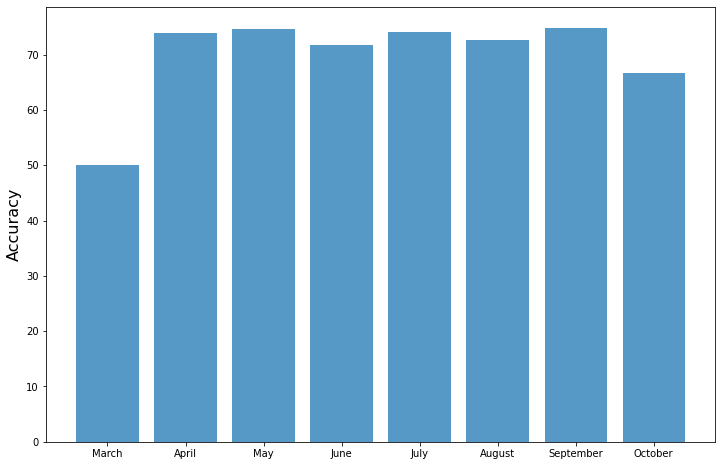

In [74]:
plt.figure(figsize=(12,8))
plt.bar(monthly_acc.index, monthly_acc[0]*100, alpha=0.75)
plt.ylabel('Accuracy', fontsize=16)
plt.xticks([0,1,2,3,4,5,6,7], ['March', 'April', 'May', 'June','July', 'August', 'September', 'October']);

In [79]:
X_train = X_train.replace([np.inf, -np.inf], 1000)
X_test = X_test.replace([np.inf, -np.inf], 1000)

In [80]:
rfc = RandomForestClassifier(criterion='entropy', n_estimators=60, max_depth=4)
forest_model = rfc.fit(X_train, y_train)

In [81]:
rfc_preds = rfc.predict(X_test)

In [82]:
accuracy_score(y_test, rfc_preds)

0.7342549923195084

In [83]:
dtc = DecisionTreeClassifier(criterion='entropy', max_features=None, max_depth=3)
tree_model = dtc.fit(X_train, y_train)

In [84]:
dtc_preds = dtc.predict(X_test)

In [85]:
accuracy_score(y_test, dtc_preds)

0.7200887523468169

In [86]:
predictions = []
for i in range(y_test.shape[0]):
  p = preds[i] + rfc_preds[i] +dtc_preds[i]


  if p >= 2:
    predictions.append(1)
  else:
    predictions.append(0)

In [87]:
accuracy_score(y_test, predictions)

0.7323775388291517

In [88]:
!pip install interpret

     |████████████████████████████████| 5.2MB 5.8MB/s 
     |████████████████████████████████| 5.3MB 42.8MB/s 
     |████████████████████████████████| 81kB 11.1MB/s 
     |████████████████████████████████| 1.8MB 50.1MB/s 
     |████████████████████████████████| 3.6MB 21.6MB/s 
     |████████████████████████████████| 471kB 56.0MB/s 
     |████████████████████████████████| 276kB 57.2MB/s 
     |████████████████████████████████| 788kB 54.3MB/s 
     |████████████████████████████████| 122kB 61.2MB/s 
     |████████████████████████████████| 860kB 58.8MB/s 
     |████████████████████████████████| 327kB 41.7MB/s 
     |████████████████████████████████| 51kB 8.3MB/s 
     |████████████████████████████████| 245kB 55.6MB/s 
     |████████████████████████████████| 1.0MB 55.7MB/s 
     |████████████████████████████████| 3.5MB 54.8MB/s 
     |████████████████████████████████| 194kB 51.7MB/s 
     |████████████████████████████████| 358kB 51.5MB/s 
     |████████████████████████████████| 358kB 35.7MB

In [89]:
from interpret.glassbox import ExplainableBoostingClassifier

ebm = ExplainableBoostingClassifier()
ebm.fit(X_train, y_train)

ExplainableBoostingClassifier(binning='quantile', early_stopping_rounds=50,
                              early_stopping_tolerance=0.0001,
                              feature_names=['M', 'D', 'home_elo', 'away_elo',
                                             'home_avg', 'away_avg', 'home_obp',
                                             'away_obp', 'home_slg', 'away_slg',
                                             'home_iso', 'away_iso', 'elo_diff',
                                             'elo_pct_diff', 'avg_diff',
                                             'obp_diff', 'slg_diff',
                                             'avg_pct_diff', 'obp_pct_diff',
                                             'slg_pct_diff', 'home_r...
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                             

In [90]:
emb_preds = ebm.predict(X_test)

In [91]:
accuracy_score(y_test, emb_preds)

0.734084314729476

In [92]:
from interpret import show

ebm_global = ebm.explain_global()
show(ebm_global)

/usr/local/lib/python3.6/dist-packages/interpret/provider/visualize.py:44: UserWarning: Cloud environment detected (['colab', 'ipython']): viz integration is still experimental.
  detected_envs


In [96]:
ebm_test = X_test[1000:1010]
emb_test_labels = y_test[1000:1010]

In [97]:
ebm_local = ebm.explain_local(ebm_test, emb_test_labels)
show(ebm_local)

In [98]:
X_test[1000:1010]

,M,D,home_elo,away_elo,home_avg,away_avg,home_obp,away_obp,home_slg,away_slg,home_iso,away_iso,elo_diff,elo_pct_diff,avg_diff,obp_diff,slg_diff,avg_pct_diff,obp_pct_diff,slg_pct_diff,home_rest,away_rest,away_team_season_game_num,home_team_season_game_num,home_Avg_Attendance_offset1year,home_W-L-pct_offset1year,away_Avg_Attendance_offset1year,away_W-L-pct_offset1year,team_home_WHIP_offset1year,team_home_ERA_offset1year,team_away_WHIP_offset1year,team_away_ERA_offset1year,pitcher_home_WHIP_offset1game,pitcher_home_ERA_offset1game,pitcher_home_IP_offset1game,pitcher_away_WHIP_offset1game,pitcher_away_ERA_offset1game,pitcher_away_IP_offset1game,home_ops,away_ops,pitcher_WHIP_diff,pitcher_ERA_diff,pitcher_IP_diff,team_WHIP_diff,W-L_diff,team_ERA_diff,ops_diff,pitcher_WHIP_pct_diff,pitcher_ERA_pct_diff,pitcher_IP_pct_diff,team_ERA_pct_diff,ops_pct_diff
24908,8.0,8.0,1473.7977,1442.7218,0.247104,0.268482,0.345638,0.321300,0.397683,0.424125,0.150579,0.155642,31.075920,2.108561,-0.021378,0.024338,-0.026441,-8.651507,7.041464,-6.648786,1.0,1.0,54,55,31511.864198,0.419753,27373.006211,0.413580,1.358188,4.28,1.411831,4.41,1.142857,3.58,7.0,1.000000,5.73,6.0,0.743321,0.745424,0.142857,-2.15,1.0,-3.949570,0.006173,-0.13,-0.002103,12.500004,-60.055866,14.285714,-3.037383,-0.282938
24909,8.0,8.0,1532.5323,1460.4779,0.243478,0.244361,0.304000,0.302083,0.439130,0.417293,0.195652,0.172932,72.054405,4.701656,-0.000883,0.001917,0.021837,-0.362513,0.630482,4.972828,1.0,1.0,59,56,40502.469136,0.567901,27260.937107,0.388889,1.184611,3.46,1.448367,4.69,1.400000,4.66,5.0,3.000000,5.54,3.0,0.743130,0.719377,-1.600000,-0.88,2.0,-22.265195,0.179012,-1.23,0.023754,-114.285714,-18.884120,40.000000,-35.549133,3.196460
24910,8.0,8.0,1553.6455,1482.1316,0.225000,0.251029,0.295455,0.338182,0.383333,0.448560,0.158333,0.197531,71.513916,4.602975,-0.026029,-0.042727,-0.065226,-11.568358,-14.461538,-17.015566,1.0,1.0,51,56,31175.968750,0.574074,21796.154321,0.493827,1.214434,3.81,1.232537,3.74,2.195122,4.61,4.1,2.156863,3.69,5.1,0.678788,0.786741,0.038259,0.92,-1.0,-1.490646,0.080247,0.07,-0.107954,1.742924,19.956616,-24.390244,1.837270,-15.903883
24911,8.0,8.0,1525.8086,1458.0869,0.231092,0.258333,0.309434,0.323194,0.373950,0.391667,0.142857,0.133333,67.721690,4.438413,-0.027241,-0.013760,-0.017717,-11.787879,-4.446815,-4.737828,1.0,1.0,55,58,37430.521739,0.617284,30965.937888,0.395062,1.253927,2.94,1.362604,4.35,2.000000,4.45,5.0,0.833333,6.36,6.0,0.683384,0.714861,1.166667,-1.91,-1.0,-8.666934,0.222222,-1.41,-0.031477,58.333335,-42.921348,-20.000000,-47.959184,-4.606053
24912,8.0,8.0,1468.2415,1531.4414,0.228814,0.265823,0.280632,0.325581,0.385593,0.481013,0.156780,0.215190,-63.200030,-4.304472,-0.037009,-0.044949,-0.095419,-16.174402,-16.017033,-24.746140,1.0,1.0,54,56,25677.901235,0.419753,29223.144654,0.500000,1.298989,4.16,1.317111,4.05,0.857143,4.29,7.0,1.333333,4.02,6.0,0.666226,0.806594,-0.476191,0.27,1.0,-1.395048,-0.080247,0.11,-0.140368,-55.555561,6.293706,14.285714,2.644231,-21.069210
24913,8.0,9.0,1510.8901,1450.6326,0.232365,0.222222,0.274510,0.284672,0.406639,0.424603,0.174274,0.202381,60.257610,3.988219,0.010143,-0.010162,-0.017964,4.365079,-3.701773,-4.417719,2.0,2.0,53,55,31209.320988,0.555556,29146.142857,0.487654,1.179045,3.45,1.329969,4.05,1.000000,3.60,6.0,1.000000,3.67,6.0,0.681149,0.709275,0.000000,-0.07,0.0,-12.800471,0.067901,-0.60,-0.028126,0.000000,-1.944444,0.000000,-17.391304,-4.129184
24914,8.0,9.0,1561.4229,1502.1190,0.269710,0.227848,0.345725,0.287938,0.427386,0.400844,0.157676,0.172996,59.303802,3.798062,0.041861,0.057787,0.026542,15.520935,16.714783,6.210315,2.0,2.0,56,54,35488.062112,0.598765,33076.444444,0.524691,1.151872,3.36,1.264408,3.94,0.500000,3.56,8.0,2.000000,5.19,5.0,0.773111,0.688782,-1.500000,-1.63,3.0,-9.769823,0.074074,-0.58,0.084329,-300.000000,-45.786517,37.500000,-17.261905,10.907773
24915,8.0,9.0,1510.2761,1478.7610,0.205479,0.280851,0.317647,0.367041,0.319635,0.451064,0.114155,0.170213,31.515175,2.086716,-0.0